## Walmart Sales EDA
## Exploratory Data Analysis

**Цели:**
- Загрузить данные из MinIO
- Понять структуру и связи между таблицами
- Оценить качество данных
- Определить типы данных для Postgres

In [1]:
# Установка библиотек (выполнить один раз)
%pip install minio pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.8/93.8 kB 499.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 5.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Импорт бибиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from minio import Minio
from io import BytesIO
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')

print('Libraries loaded successfully!')

Libraries loaded successfully!


### 1. Подключение к Minio и загрузка данных

In [75]:
# Подкючение к Minio
minio_client = Minio(
    endpoint=os.getenv('MINIO_ENDPOINT'),
    access_key= os.getenv('MINIO_ACCESS_KEY'),
    secret_key= os.getenv('MINIO_SECRET_KEY'),
    secure=False
)

BUCKET_NAME = 'walmart-raw'

# Список файлов в bucket
objects = minio_client.list_objects(BUCKET_NAME, prefix='raw/', recursive=True)
files = [obj.object_name for obj in objects]
print('Files in Minio:')
for f in files:
    print(f' - {f}')
print(f'\nDownloaded {len(files)} files')

Files in Minio:
 - raw/customers.csv
 - raw/geolocation.csv
 - raw/order_items.csv
 - raw/orders.csv
 - raw/payments.csv
 - raw/products.csv
 - raw/sellers.csv
 - raw/walmart_trustpilot_reviews.csv

Downloaded 8 files


In [115]:
def load_csv_from_minio(object_name):
    """Загружает CSV файл из MinIO в DataFrame"""
    response = minio_client.get_object(BUCKET_NAME, object_name)
    df = pd.read_csv(BytesIO(response.read()))
    response.close()
    response.release_conn()
    return df

# Загрузка всех датасетов
print("Loading tables...")

df_customers = load_csv_from_minio('raw/customers.csv')
df_geolocation = load_csv_from_minio('raw/geolocation.csv')
df_orders = load_csv_from_minio('raw/orders.csv')
df_order_items = load_csv_from_minio('raw/order_items.csv')
df_payments = load_csv_from_minio('raw/payments.csv')
df_products = load_csv_from_minio('raw/products.csv')
df_sellers = load_csv_from_minio('raw/sellers.csv')
df_reviews = load_csv_from_minio('raw/walmart_trustpilot_reviews.csv')

print('All tables loaded!')

Loading tables...
All tables loaded!


### 2. Обзор структуры данных

In [116]:
# Словарь всех таблиц
datasets = {
    'customers': df_customers,
    'geolocation': df_geolocation,
    'orders': df_orders,
    'order_items': df_order_items,
    'payments': df_payments,
    'products': df_products,
    'sellers': df_sellers,
    'reviews': df_reviews
}

# Размеры таблиц
print('-' * 50, 'Размеры таблиц', '-' * 50, sep='\n')
for name, value in datasets.items():
    print(f'{name:20} | {value.shape[0]:>10} rows | {value.shape[1]:>3} cols |')

--------------------------------------------------
Размеры таблиц
--------------------------------------------------
customers            |      99441 rows |   5 cols |
geolocation          |    1000163 rows |   5 cols |
orders               |      99441 rows |   8 cols |
order_items          |     112650 rows |   7 cols |
payments             |     103886 rows |   5 cols |
products             |      32951 rows |   9 cols |
sellers              |       3095 rows |   4 cols |
reviews              |       3671 rows |   6 cols |


In [117]:
# Детальная информация по каждой таблице
def dataset_overview(name, df):
    print(f'{name.upper()}', '-' * 60, sep='\n')
    print(f'Shape: {df.shape}')
    print(f'\nColumns & Rows', df.dtypes, sep='\n')
    print(f'\nFirst 3 rows:')
    display(df.head(3))
    print(f'\nMissing values:', sep='\n')
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)
    missing_df = pd.DataFrame({'missing': missing, 'percent': missing_pct})
    print(missing_df[missing_df['missing'] > 0], '_' * 60, sep='\n')
    
# Просмотр каждой таблицы
for name, value in datasets.items():
    dataset_overview(name, value)

CUSTOMERS
------------------------------------------------------------
Shape: (99441, 5)

Columns & Rows
customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

First 3 rows:


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________
GEOLOCATION
------------------------------------------------------------
Shape: (1000163, 5)

Columns & Rows
geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object

First 3 rows:


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________
ORDERS
------------------------------------------------------------
Shape: (99441, 8)

Columns & Rows
order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

First 3 rows:


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



Missing values:
                               missing  percent
order_approved_at                  160     0.16
order_delivered_carrier_date      1783     1.79
order_delivered_customer_date     2965     2.98
____________________________________________________________
ORDER_ITEMS
------------------------------------------------------------
Shape: (112650, 7)

Columns & Rows
order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

First 3 rows:


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________
PAYMENTS
------------------------------------------------------------
Shape: (103886, 5)

Columns & Rows
order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object

First 3 rows:


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________
PRODUCTS
------------------------------------------------------------
Shape: (32951, 9)

Columns & Rows
product_id                     object
product category               object
product_name_length           float64
product_description_length    float64
product_photos_qty            float64
product_weight_g              float64
product_length_cm             float64
product_height_cm             float64
product_width_cm              float64
dtype: object

First 3 rows:


,product_id,product category,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,Art,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sport leisure,46.0,250.0,1.0,154.0,18.0,9.0,15.0



Missing values:
                            missing  percent
product category                610     1.85
product_name_length             610     1.85
product_description_length      610     1.85
product_photos_qty              610     1.85
product_weight_g                  2     0.01
product_length_cm                 2     0.01
product_height_cm                 2     0.01
product_width_cm                  2     0.01
____________________________________________________________
SELLERS
------------------------------------------------------------
Shape: (3095, 4)

Columns & Rows
seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object

First 3 rows:


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________
REVIEWS
------------------------------------------------------------
Shape: (3671, 6)

Columns & Rows
reviewer_name      object
review_time        object
star_rating        object
headline           object
review_content     object
experience_time    object
dtype: object

First 3 rows:


,reviewer_name,review_time,star_rating,headline,review_content,experience_time
0,Stephanye Bauer,2025-03-13T23:22:57.000Z,Rated 1 out of 5 stars,Maybe President Trump and Melania shop…,Maybe President Trump and Melania shop at walm...,"March 10, 2025"
1,A STORM IS COMING A Storm is C,2025-03-13T01:33:55.000Z,Rated 1 out of 5 stars,walmart has bad customers service and…,walmart has bad customers service and outfits ...,"March 03, 2025"
2,N Fan,2025-03-12T10:11:47.000Z,Rated 2 out of 5 stars,Expensive and messy,Expensive and messy don't even keep their shel...,"March 02, 2025"



Missing values:
Empty DataFrame
Columns: [missing, percent]
Index: []
____________________________________________________________


- Все таблицы практические полные, отсутствие данных не критично для дальнейшего анализа

### 3. Анализ связи между таблицами

In [104]:
# Проверка уникальных ключей
print('-' * 60, 'Проверка первичных ключей', '-' * 60, sep='\n')

pk_checks = [
    ('customers', 'customer_id', df_customers),
    ('orders', 'order_id', df_orders),
    ('sellers', 'seller_id', df_sellers),
    ('products', 'product_id', df_products)
]

for table, pk, df in pk_checks:
    total = len(df)
    unique = df[pk].nunique()
    is_unique = 'Unique' if total == unique else 'Duplicates'
    print(f'{table:20} | {pk:15} | {is_unique} ({unique}/{total})')

------------------------------------------------------------
Проверка первичных ключей
------------------------------------------------------------
customers            | customer_id     | Unique (99441/99441)
orders               | order_id        | Unique (99441/99441)
sellers              | seller_id       | Unique (3095/3095)
products             | product_id      | Unique (32951/32951)


- Все пер

In [96]:
# Проверка Foreign Key связей
print('-' * 50, 'Проверка Foreign Key связей', '-' * 50, sep='\n')

fk_checks = [
    ('orders.customer_id', df_orders.customer_id, df_customers.customer_id),
    ('order_items.order_id', df_order_items.order_id, df_orders.order_id),
    ('order_items.seller_id', df_order_items.seller_id, df_sellers.seller_id),
    ('order_items.product_id', df_order_items.product_id, df_products.product_id),
    ('payments.order_id', df_payments.order_id, df_orders.order_id)
]

# Целостность внешних ключей
for name, child_col, parent_col in fk_checks:
    orphans = set(child_col) - set(parent_col)
    """ если кол-во строк двух ключевых строк таблиц одинаковые, значит внешн ключи совподают """
    status = 'OK' if len(orphans) == 0 else f'{len(orphans)} orphans'
    print(f'{name:35} | {status:10} |')

--------------------------------------------------
Проверка Foreign Key связей
--------------------------------------------------
orders.customer_id                  | OK         |
order_items.order_id                | OK         |
order_items.seller_id               | OK         |
order_items.product_id              | OK         |
payments.order_id                   | OK         |


- так как статус положителен, данные целостные, потерянных внешних ключей нет, каждая запись в дочерней таблице имеет соответствующего родителя

### 4. Качество данных

In [113]:
# Проверка даты
print('-' * 50, 'Проверка даты', '-' * 50, sep='\n')

date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date']

for col in date_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    print(f'{col}')
    print(f'Min: {df_orders[col].min()}', f'Max: {df_orders[col].max()}', sep='\n', end='\n\n')

--------------------------------------------------
Проверка даты
--------------------------------------------------
order_purchase_timestamp
Min: 2016-09-04 21:15:19
Max: 2018-10-17 17:30:18

order_approved_at
Min: 2016-09-15 12:16:38
Max: 2018-09-03 17:40:06

order_delivered_carrier_date
Min: 2016-10-08 10:34:01
Max: 2018-09-11 19:48:28

order_delivered_customer_date
Min: 2016-10-11 13:46:32
Max: 2018-10-17 13:22:46

order_estimated_delivery_date
Min: 2016-09-30 00:00:00
Max: 2018-11-12 00:00:00



- данные относятся периоду 2016-18 годов

In [120]:
# Статус заказов
print('-' * 50, 'Статус заказов', '-' * 50, sep='\n')
print(df_orders.order_status.value_counts())

--------------------------------------------------
Статус заказов
--------------------------------------------------
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64


In [122]:
# Типы оплаты
print('-' * 50, 'Типы оплаты', '-' * 50, sep='\n')
print(df_payments.payment_type.value_counts())

--------------------------------------------------
Типы оплаты
--------------------------------------------------
payment_type
credit_card    76795
UPI            19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64


### 5. Базовые метрики для бизнес-анализа

In [129]:
# Общая выручка
total_revenue = sum(df_order_items['price']) + sum(df_order_items['freight_value'])
print(f'Общая выручка: {total_revenue:,.2f}')

# Средний чек
avg_order_value = df_order_items.groupby('order_id')['price'].sum().mean()
print(f'Средний чек: {avg_order_value:,.2f}')

# Кол-во клиентов
unique_customers = df_customers.customer_unique_id.nunique()
print(f'Уникальных покупателей: {unique_customers:,.0f}')

# Кол-во продавцов
unique_sellers = df_sellers.seller_id.nunique()
print(f'Количество продавцов: {unique_sellers:,.0f}')

# Кол-во товаров
products = df_products.product_id.nunique()
print(f'Продуктов: {products:,.2f}')

Общая выручка: 15,843,553.24
Средний чек: 137.75
Уникальных покупателей: 96,096
Количество продавцов: 3,095
Продуктов: 32,951.00


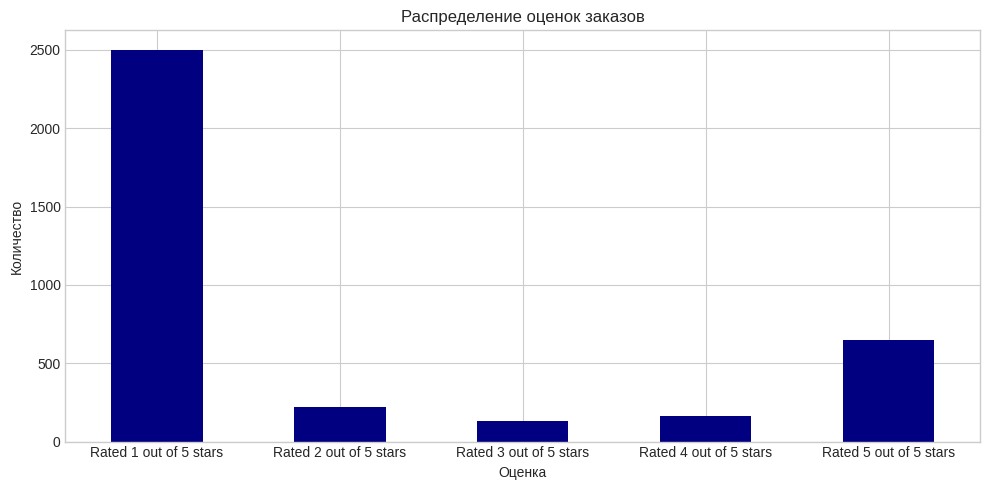

In [133]:
# Распределение оценок заказов
plt.figure(figsize=(10,5))
df_reviews.star_rating.value_counts().sort_index().plot(kind='bar', color='navy')
plt.title('Распределение оценок заказов')
plt.xlabel('Оценка')
plt.ylabel('Количество')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

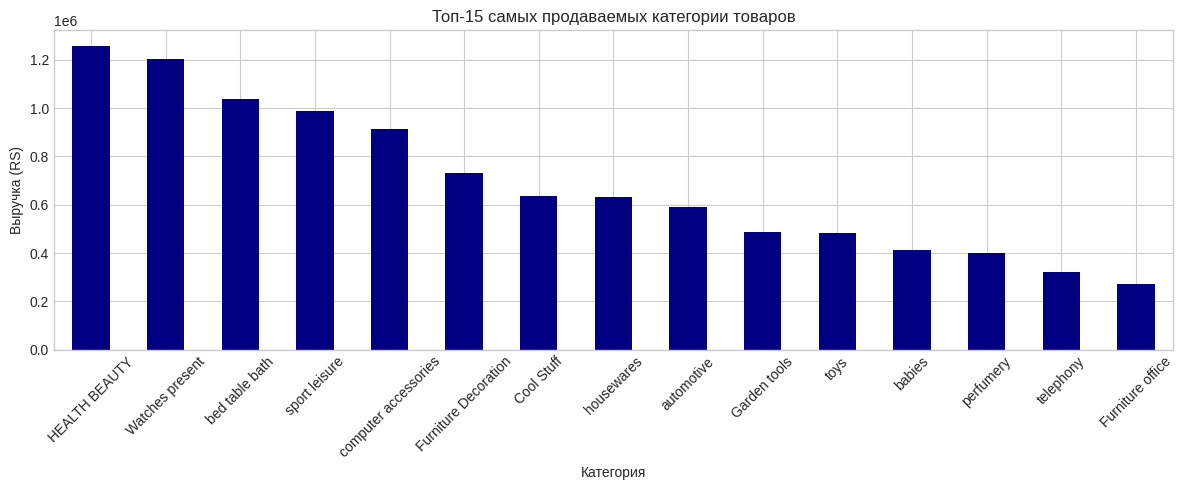

In [137]:
# Топ категории по продажам
df_items_products = df_order_items.merge(df_products, on='product_id')

top_categories = df_items_products.groupby('product category').price.sum().sort_values(ascending=False).head(15)

# распределение
plt.figure(figsize=(12,5))
top_categories.plot(kind='bar', color='navy')
plt.title('Топ-15 самых продаваемых категории товаров')
plt.xlabel('Категория')
plt.ylabel('Выручка (RS)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()